In [113]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Setup

In [114]:
import os
from typing import Callable

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

from functools import partial
import numpy as np

import blackjax
import h5py
import jax
import jax.numpy as jnp
import jax.scipy as jsp
from jax.scipy import stats
import matplotlib.pyplot as plt
from jax import jit as jjit
from jax import random, vmap
from jax import random
from tqdm import tqdm

from bpd.io import save_dataset_h5py, load_dataset_h5py
from bpd.diagnostics import get_contour_plot
from bpd.chains import inference_loop

jax.config.update("jax_enable_x64", True)

In [45]:
GPU = jax.devices("gpu")[0]

In [46]:
from bpd.likelihood import shear_loglikelihood, shear_loglikelihood_unreduced
from bpd.prior import ellip_mag_prior, sample_ellip_prior, sample_synthetic_sheared_ellips_unclipped

In [47]:
def log_target(e_sheared, e_obs, sigma_m, interim_prior: Callable = None):
    assert e_sheared.shape == (2,) and e_obs.shape == (2,)

    # ignore angle because flat
    # prior enforces magnitude < 1.0 for posterior samples
    e_sheared_mag = jnp.sqrt(e_sheared[0] ** 2 + e_sheared[1] ** 2)
    prior = jnp.log(interim_prior(e_sheared_mag))

    likelihood = jnp.sum(jsp.stats.norm.logpdf(e_obs, loc=e_sheared, scale=sigma_m))
    return prior + likelihood


def do_inference(rng_key, init_positions, e_obs, sigma_m, sigma_e, m=10):
    interim_prior = partial(ellip_mag_prior, sigma=sigma_e * 2)
    _logtarget = partial(
        log_target, e_obs=e_obs, sigma_m=sigma_m, interim_prior=interim_prior
    )

    key1, key2 = random.split(rng_key)

    warmup = blackjax.window_adaptation(
        blackjax.nuts,
        _logtarget,
        progress_bar=False,
        is_mass_matrix_diagonal=True,
        max_num_doublings=5,
        initial_step_size=0.01,
        target_acceptance_rate=0.80,
    )

    (init_states, tuned_params), _ = warmup.run(key1, init_positions, 500)
    kernel = blackjax.nuts(_logtarget, **tuned_params).step
    states, _ = inference_loop(key2, init_states, kernel=kernel, n_samples=m)
    return states.position

In [48]:
def get_all_loglikes(g1s, e_post, sigma_e):
    prior = partial(ellip_mag_prior, sigma=sigma_e)
    interim_prior = partial(ellip_mag_prior, sigma=sigma_e * 2)
    _loglikelihood = jax.jit(partial(shear_loglikelihood_unreduced, prior=prior, interim_prior=interim_prior))

    _all_likes = []
    for g1 in g1s:
        likes = _loglikelihood((g1, 0.), e_post)
        _all_likes.append(likes)

    return jnp.array(_all_likes)


In [49]:
def _scale_likelihood(arr, axis=0):
    """Return the likelihood from log-likelihood, scale according to shear range."""
    assert arr.ndim in {1,2}
    max_val = jnp.max(arr, axis=axis)  # Find the maximum value to subtract from the array

    if arr.ndim == 1:
        return jnp.exp(arr - max_val)
    else: 
        _shape = (1, -1) if axis==0 else (-1, 1)
        return jnp.exp(arr - max_val.reshape(_shape))

# First case (function of n_samples)

## Get samples

In [78]:
key = random.key(43)
k1, k2 = random.split(key)

g = 0.02, 0.
n_gals = int(1e5)

sigma_m = 0.001
sigma_e = 0.01

In [79]:
e_obs, e_sheared, _ = sample_synthetic_sheared_ellips_unclipped(
    k1, g, n=n_gals, sigma_m=sigma_m, sigma_e=sigma_e
)
e_obs.shape

(100000, 2)

In [80]:
keys2 = random.split(k2, n_gals)
_do_inference = partial(do_inference, sigma_e=sigma_e, sigma_m=sigma_m, m=100)
e_post = jax.vmap(_do_inference, in_axes=(0, 0, 0))(keys2, e_sheared, e_obs)
e_post.shape

2024-09-23 13:09:56.572683: W external/xla/xla/service/hlo_rematerialization.cc:3005] Can't reduce memory use below 14.15GiB (15193090452 bytes) by rematerialization; only reduced to 14.36GiB (15424109168 bytes), down from 14.37GiB (15429009368 bytes) originally


(100000, 100, 2)

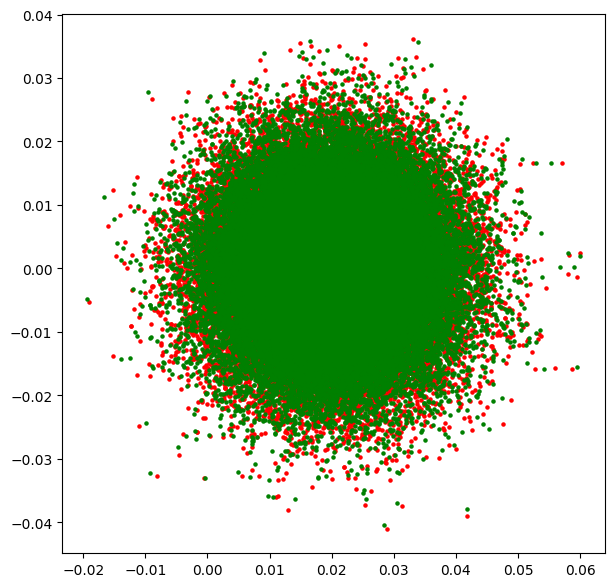

In [81]:
# sanity
plt.figure(figsize=(7,7))
plt.scatter(e_obs[:, 0], e_obs[:, 1], color='r', s=5)
plt.scatter(e_sheared[:, 0], e_sheared[:, 1], color='g', s=5)

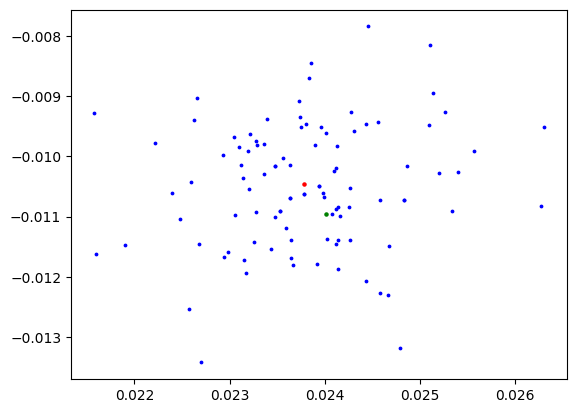

In [82]:
# sanity
plt.scatter(e_post[0, :, 0], e_post[0, :, 1], color='b', s=3)
plt.scatter(e_obs[0, 0], e_obs[0, 1], color='r', s=5)
plt.scatter(e_sheared[0, 0], e_sheared[0, 1], color='g', s=5)

## Peak as a function of n_samples

In [83]:
g1s = jnp.arange(0.018, 0.022, 0.00001) # resolution of shear 
g1s.shape

(400,)

In [84]:
all_loglikes = get_all_loglikes(g1s, e_post, sigma_e=sigma_e)
all_loglikes.shape

(400, 100000)

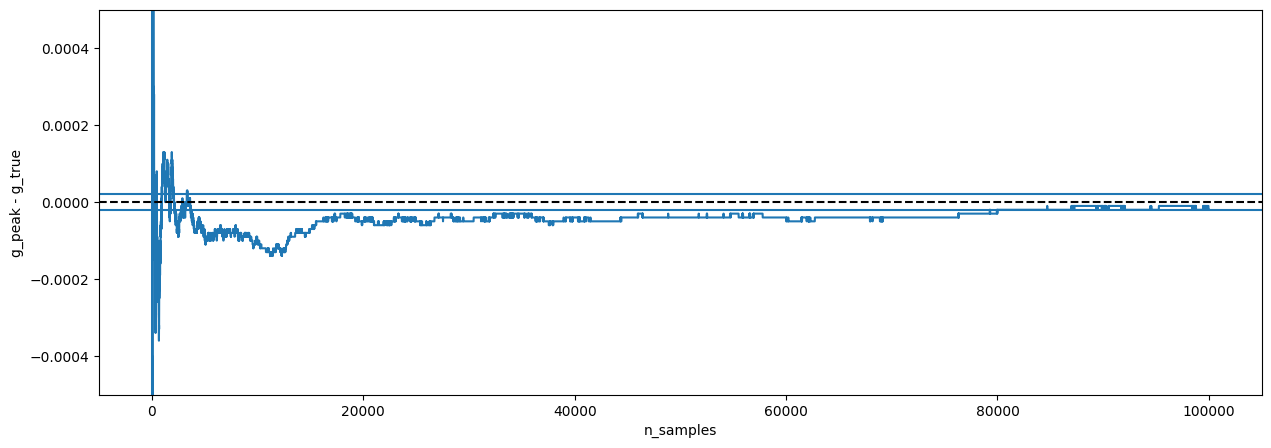

In [87]:
# deviation from shear as a function fo samples
ns = np.arange(1, n_gals+1, 1)
_cumsum_like = jnp.cumsum(all_loglikes, axis=-1)
g1_peaks = g1s[jnp.argmax(_cumsum_like, axis=0)]

plt.figure(figsize=(15, 5))
plt.plot(ns, g1_peaks - 0.02)
# plt.xscale('log')
plt.axhline(0.0, color='k', linestyle='--')
_cumsum_like.shape

plt.xlabel("n_samples")
plt.ylabel("g_peak - g_true")

plt.ylim(-0.0005, 0.0005)

plt.axhline(0.02/1000 * 2)
plt.axhline(-0.02/1000 * 2)

In [ ]:
jnp.abs((g_true - g_mean) / g_true) < 2e-3

## Width of curves as function of samples

In [88]:
g1s = jnp.arange(0.00, 0.04, 0.0001) # less resolution OK, need to reach 90%
g1s.shape

(400,)

In [89]:
all_loglikes = get_all_loglikes(g1s, e_post, sigma_e=sigma_e)

In [90]:
jnp.array([1,2,3]).reshape((1, -1))

Array([[1, 2, 3]], dtype=int64)

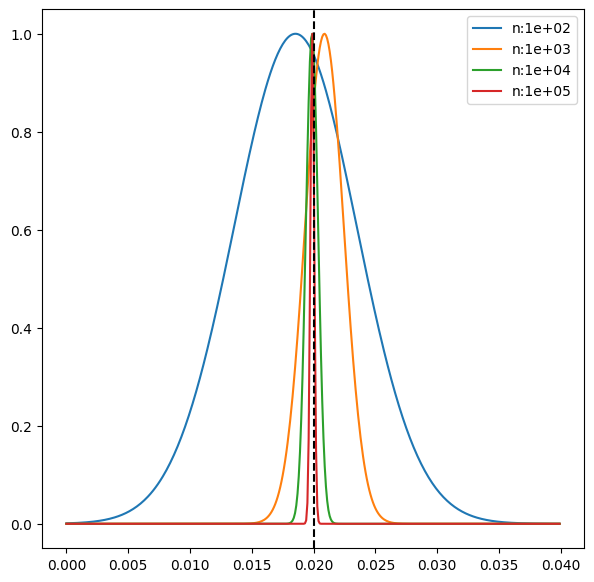

In [91]:
# this one decreases as a function of samples!
plt.figure(figsize=(7,7))

for ii in (100, 1_000, 10_000, 100_000,):

    _like = all_loglikes[:, :ii].sum(axis=-1)
    _like1 = _scale_likelihood(_like)
    plt.plot(g1s, _like1, '-', label=f"n:{ii:.2g}")
    # plt.xlim(0.015, 0.025)
plt.legend()
plt.axvline(0.02, color='k', linestyle='--')
# plt.ylim(0, 1.5)
# plt.axhline(0.9)
# plt.axvline(0.0137)

In [92]:
# # log-likelihoood width is pretty constant
# plt.figure(figsize=(7,7))

# for ii in (100, 1_000, 10_000, 100_000,):

#     _like = all_likes[:, :ii].sum(axis=-1)
#     _like = _like / _like.max() ### ERROR the devision is weird in log space
#     plt.plot(gs1, _like, '-', label=f"n:{ii:.2g}")
#     # plt.xlim(0.015, 0.025)
# plt.legend()
# plt.axvline(0.02, color='k', linestyle='--')
# # plt.ylim(0, 1.5)
# plt.axhline(0.9)
# plt.axvline(0.0137)

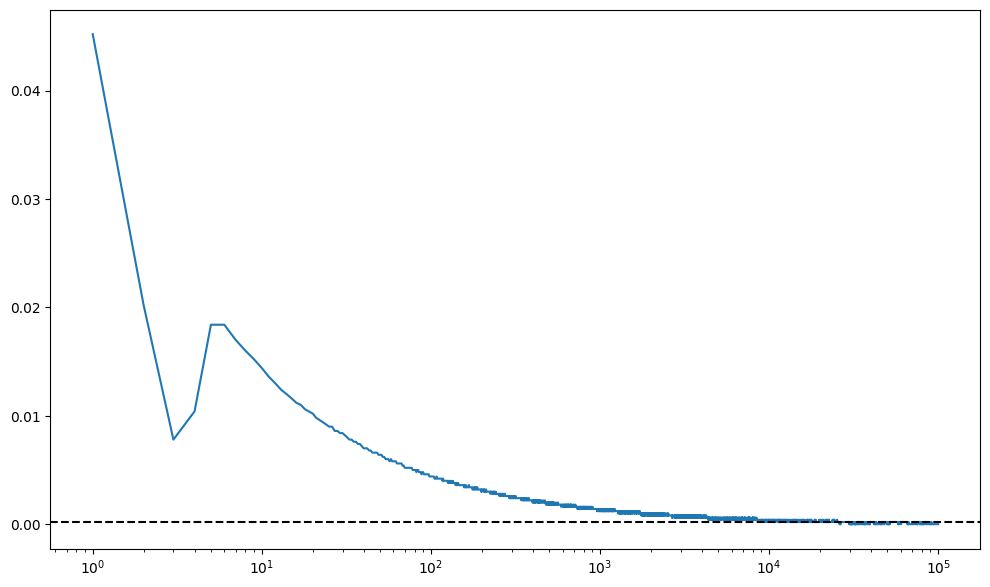

In [93]:
# define width at point at which we reach 90%
plt.figure(figsize=(12, 7))
ns = jnp.arange(1, n_gals+1, 1)
_cumsum_loglike = jnp.cumsum(all_likes, axis=-1)
_cumsum_like = _scale_likelihood(_cumsum_loglike, axis=0)

_other_indx = jnp.argmax(_cumsum_like >= 0.9, axis=0) # first index that reaches 90%
_peak_indx = jnp.argmax(_cumsum_like, axis=0)

_width = (g1s[_peak_indx] - g1s[_other_indx]) * 2

plt.plot(ns, _width)

plt.xscale('log')

plt.axhline(0.02 / 100, color='k', linestyle='--', label="1% of shear value")

# width = c


# Second case as a function of sigma_m, fixed sigma_e

In [30]:
from tqdm import tqdm

In [31]:
key = random.key(40)
k1, k2 = random.split(key)

g = 0.02, 0.
n_gals = int(1e5)

sigma_e = 0.01

In [32]:
sigma_ms = jnp.arange(0.001, 0.011, 0.001)
sigma_ms

Array([0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009,
       0.01 ], dtype=float64)

100%|██████████| 5/5 [00:54<00:00, 10.97s/it]


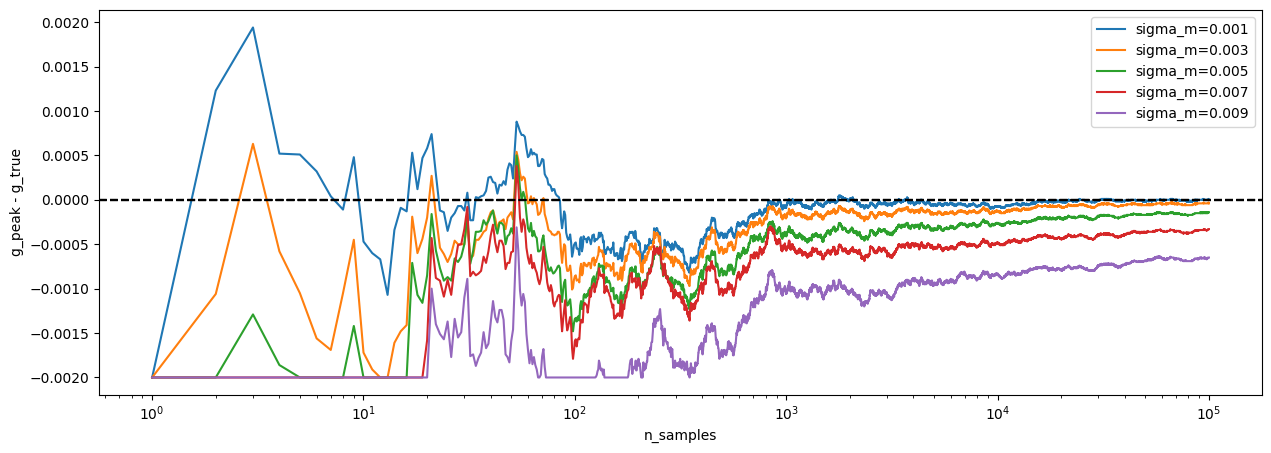

In [133]:
g1s = jnp.arange(0.018, 0.022, 0.00001)
plt.figure(figsize=(15, 5))

for sigma_m in tqdm(sigma_ms[::2]):
    
    e_obs, e_sheared, _ = sample_synthetic_sheared_ellips_unclipped(
    k1, g, n=n_gals, sigma_m=sigma_m, sigma_e=sigma_e
    )
    keys2 = random.split(k2, n_gals)
    _do_inference = partial(do_inference, sigma_e=sigma_e, sigma_m=sigma_m, m=10)
    e_post = jax.vmap(_do_inference, in_axes=(0, 0, 0))(keys2, e_sheared, e_obs)

    all_loglikes = get_all_loglikes(g1s, e_post, sigma_e=sigma_e)

    
    # plot
    ns = np.arange(1, n_gals+1, 1)
    _cumsum_like = jnp.cumsum(all_loglikes, axis=-1)
    g1_peaks = g1s[jnp.argmax(_cumsum_like, axis=0)]

    plt.plot(ns, g1_peaks - 0.02, label=f"sigma_m={sigma_m:.2g}")
    # plt.xscale('log')
    plt.axhline(0.0, color='k', linestyle='--')

    plt.xlabel("n_samples")
    plt.ylabel("g_peak - g_true")

    # plt.ylim(-0.0005, 0.0005)

    # plt.axhline(0.02/1000)
    # plt.axhline(-0.02/1000)
plt.legend()
plt.xscale("log")


  0%|          | 0/5 [00:00<?, ?it/s]2024-09-23 14:34:08.677925: W external/xla/xla/service/hlo_rematerialization.cc:3005] Can't reduce memory use below 14.15GiB (15193090444 bytes) by rematerialization; only reduced to 14.36GiB (15424109192 bytes), down from 14.37GiB (15429009392 bytes) originally

 20%|██        | 1/5 [00:12<00:48, 12.21s/it]2024-09-23 14:34:20.938556: W external/xla/xla/service/hlo_rematerialization.cc:3005] Can't reduce memory use below 14.15GiB (15193090444 bytes) by rematerialization; only reduced to 14.36GiB (15424109192 bytes), down from 14.37GiB (15429009392 bytes) originally

 40%|████      | 2/5 [00:23<00:35, 11.92s/it]2024-09-23 14:34:34.449618: W external/xla/xla/service/hlo_rematerialization.cc:3005] Can't reduce memory use below 14.15GiB (15193090444 bytes) by rematerialization; only reduced to 14.36GiB (15424109192 bytes), down from 14.37GiB (15429009392 bytes) originally

 60%|██████    | 3/5 [00:37<00:25, 12.67s/it]2024-09-23 14:34:46.182130: W exter

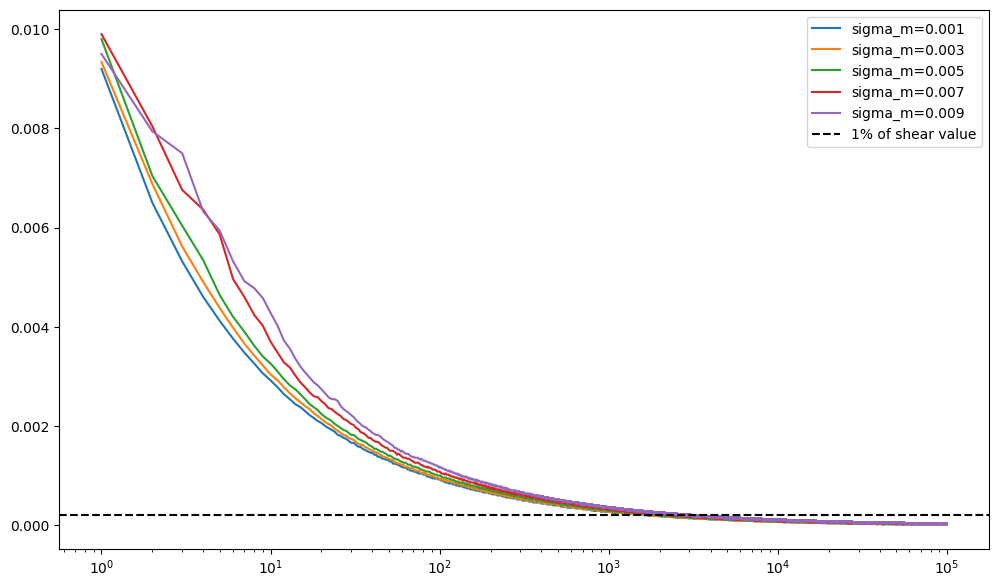

In [34]:
g1s = jnp.arange(0.00, 0.04, 0.00001)
plt.figure(figsize=(12, 7))

for sigma_m in tqdm(sigma_ms[::2]):
    
    e_obs, e_sheared, _ = sample_synthetic_sheared_ellips_unclipped(
    k1, g, n=n_gals, sigma_m=sigma_m, sigma_e=sigma_e
    )
    keys2 = random.split(k2, n_gals)
    _do_inference = partial(do_inference, sigma_e=sigma_e, sigma_m=sigma_m, m=10)
    e_post = jax.vmap(_do_inference, in_axes=(0, 0, 0))(keys2, e_sheared, e_obs)

    all_loglikes = get_all_loglikes(g1s, e_post, sigma_e=sigma_e)

    
    # plot
    ns = jnp.arange(1, n_gals+1, 1)
    _cumsum_loglike = jnp.cumsum(all_loglikes, axis=-1)
    _cumsum_like = _scale_likelihood(_cumsum_loglike, axis=0)

    _other_indx = jnp.argmax(_cumsum_like >= 0.9, axis=0) # first index that reaches 90%
    _peak_indx = jnp.argmax(_cumsum_like, axis=0)

    _width = (g1s[_peak_indx] - g1s[_other_indx]) * 2

    plt.plot(ns, _width, label=f"sigma_m={sigma_m:.2g}")

    plt.xscale('log')

plt.axhline(0.02 / 100, color='k', linestyle='--', label="1% of shear value")
plt.legend()

100%|██████████| 5/5 [00:52<00:00, 10.50s/it]


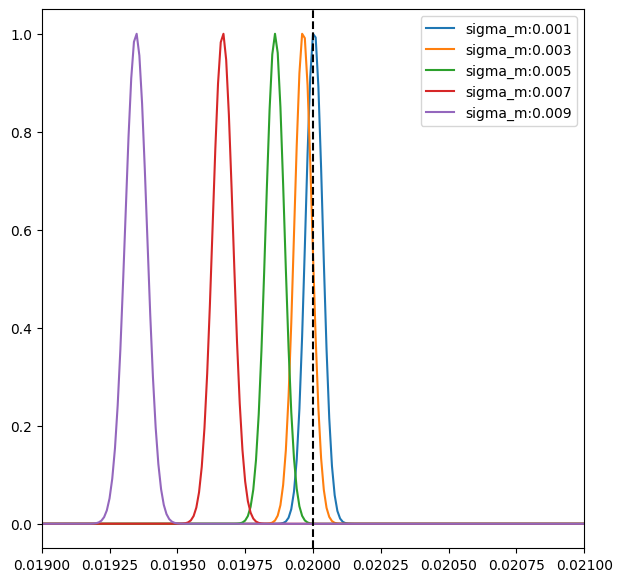

In [136]:
# plot of likelihood for different sigma_m with full dataset
plt.figure(figsize=(7,7))

g1s = jnp.arange(0.018, 0.022, 0.00001)

for sigma_m in tqdm(sigma_ms[::2]):
    
    e_obs, e_sheared, _ = sample_synthetic_sheared_ellips_unclipped(
    k1, g, n=n_gals, sigma_m=sigma_m, sigma_e=sigma_e
    )
    keys2 = random.split(k2, n_gals)
    _do_inference = partial(do_inference, sigma_e=sigma_e, sigma_m=sigma_m, m=10)
    e_post = jax.vmap(_do_inference, in_axes=(0, 0, 0))(keys2, e_sheared, e_obs)

    all_loglikes = get_all_loglikes(g1s, e_post, sigma_e=sigma_e)
    
    _likes = all_loglikes.sum(axis=-1)
    _like1 = _scale_likelihood(_likes)
    plt.plot(g1s, _like1, '-', label=f"sigma_m:{sigma_m:.2g}")
plt.xlim(0.019, 0.021)
plt.legend()
plt.axvline(0.02, color='k', linestyle='--')
# plt.ylim(0, 1.5)
# plt.axhline(0.9)
# plt.axvline(0.0137)

In [13]:
n_gals

100000

## Function of `m`

100%|██████████| 6/6 [01:16<00:00, 12.81s/it]


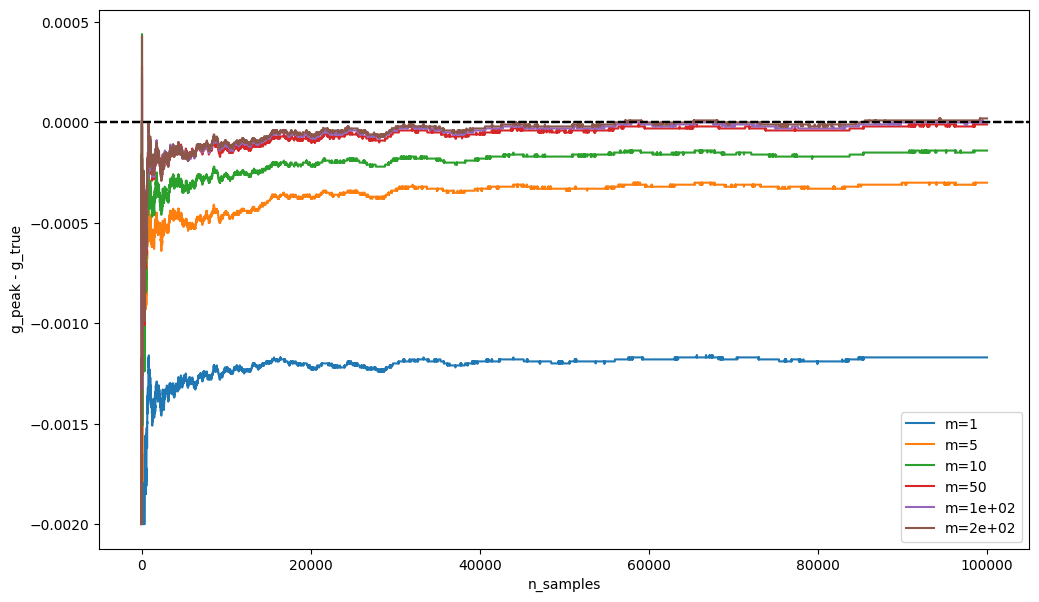

In [11]:
# bias and width as function of m , fixed sigma_m=0.005
sigma_m = 0.005

g1s = jnp.arange(0.018, 0.022, 0.00001)


plt.figure(figsize=(12, 7))
ms = (1, 5, 10, 50, 100, 200)


for m in tqdm(ms):
    e_obs, e_sheared, _ = sample_synthetic_sheared_ellips_unclipped(
    k1, g, n=n_gals, sigma_m=sigma_m, sigma_e=sigma_e
    )
    keys2 = random.split(k2, n_gals)
    _do_inference = partial(do_inference, sigma_e=sigma_e, sigma_m=sigma_m, m=m)
    e_post = jax.vmap(_do_inference, in_axes=(0, 0, 0))(keys2, e_sheared, e_obs)

    all_loglikes = get_all_loglikes(g1s, e_post, sigma_e=sigma_e)

    
    # plot
    ns = np.arange(1, n_gals+1, 1)
    _cumsum_like = jnp.cumsum(all_loglikes, axis=-1)
    g1_peaks = g1s[jnp.argmax(_cumsum_like, axis=0)]

    plt.plot(ns, g1_peaks - 0.02, label=f"m={m:.2g}")
    plt.axhline(0.0, color='k', linestyle='--')

    plt.xlabel("n_samples")
    plt.ylabel("g_peak - g_true")

# plt.axhline(0.02 / 100, color='k', linestyle='--', label="1% of shear value")
plt.legend()

100%|██████████| 6/6 [01:09<00:00, 11.53s/it]


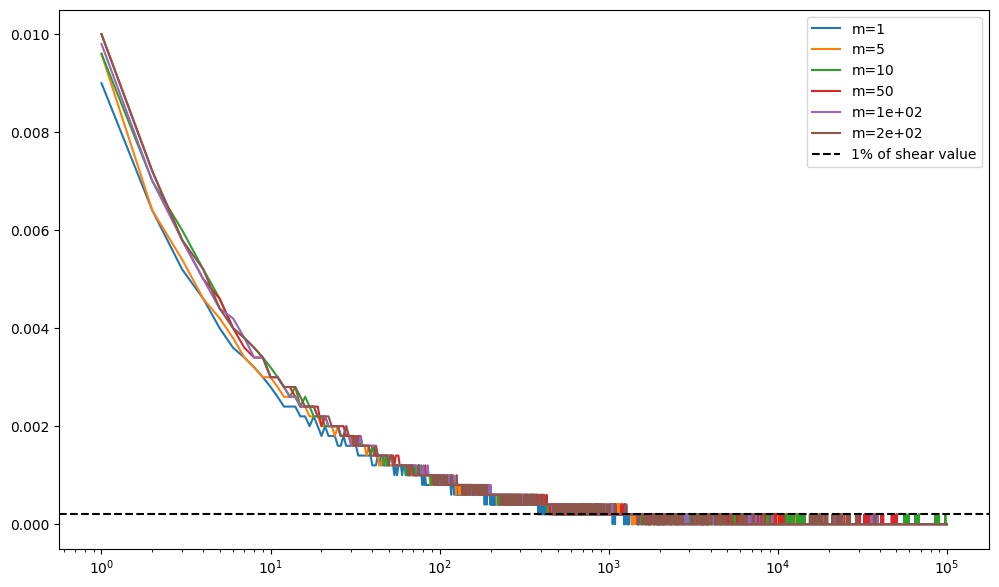

In [17]:
# bias and width as function of m , fixed sigma_m=0.005
sigma_m = 0.005

g1s = jnp.arange(0.00, 0.04, 0.0001)



plt.figure(figsize=(12, 7))
ms = (1, 5, 10, 50, 100, 200)


for m in tqdm(ms):
    e_obs, e_sheared, _ = sample_synthetic_sheared_ellips_unclipped(
    k1, g, n=n_gals, sigma_m=sigma_m, sigma_e=sigma_e
    )
    keys2 = random.split(k2, n_gals)
    _do_inference = partial(do_inference, sigma_e=sigma_e, sigma_m=sigma_m, m=m)
    e_post = jax.vmap(_do_inference, in_axes=(0, 0, 0))(keys2, e_sheared, e_obs)

    all_loglikes = get_all_loglikes(g1s, e_post, sigma_e=sigma_e)

    
    # plot
    ns = jnp.arange(1, n_gals+1, 1)
    _cumsum_loglike = jnp.cumsum(all_loglikes, axis=-1)
    _cumsum_like = _scale_likelihood(_cumsum_loglike, axis=0)

    _other_indx = jnp.argmax(_cumsum_like >= 0.9, axis=0) # first index that reaches 90%
    _peak_indx = jnp.argmax(_cumsum_like, axis=0)

    _width = (g1s[_peak_indx] - g1s[_other_indx]) * 2

    plt.plot(ns, _width, label=f"m={m:.2g}")

    plt.xscale('log')

plt.axhline(0.02 / 100, color='k', linestyle='--', label="1% of shear value")
plt.legend()

# Third case (decrease both sigma_m and sigma_e)

In [18]:
from tqdm import tqdm

In [19]:
sigma_ms = (1e-4, 1e-3, 1e-2)
sigma_es = (1e-3, 1e-2, 1e-1)

In [20]:
key = random.key(40)
k1, k2 = random.split(key)

g = 0.02, 0.
n_gals = int(1e5)

0it [00:00, ?it/s]2024-09-23 14:24:46.338855: W external/xla/xla/service/hlo_rematerialization.cc:3005] Can't reduce memory use below 14.15GiB (15193090452 bytes) by rematerialization; only reduced to 14.36GiB (15424109168 bytes), down from 14.37GiB (15429009368 bytes) originally
1it [00:11, 11.16s/it]2024-09-23 14:24:57.458478: W external/xla/xla/service/hlo_rematerialization.cc:3005] Can't reduce memory use below 14.15GiB (15193090452 bytes) by rematerialization; only reduced to 14.36GiB (15424109168 bytes), down from 14.37GiB (15429009368 bytes) originally
2it [00:22, 11.11s/it]2024-09-23 14:25:09.858888: W external/xla/xla/service/hlo_rematerialization.cc:3005] Can't reduce memory use below 14.15GiB (15193090452 bytes) by rematerialization; only reduced to 14.36GiB (15424109168 bytes), down from 14.37GiB (15429009368 bytes) originally
3it [00:34, 11.59s/it]


(-0.001, 0.001)

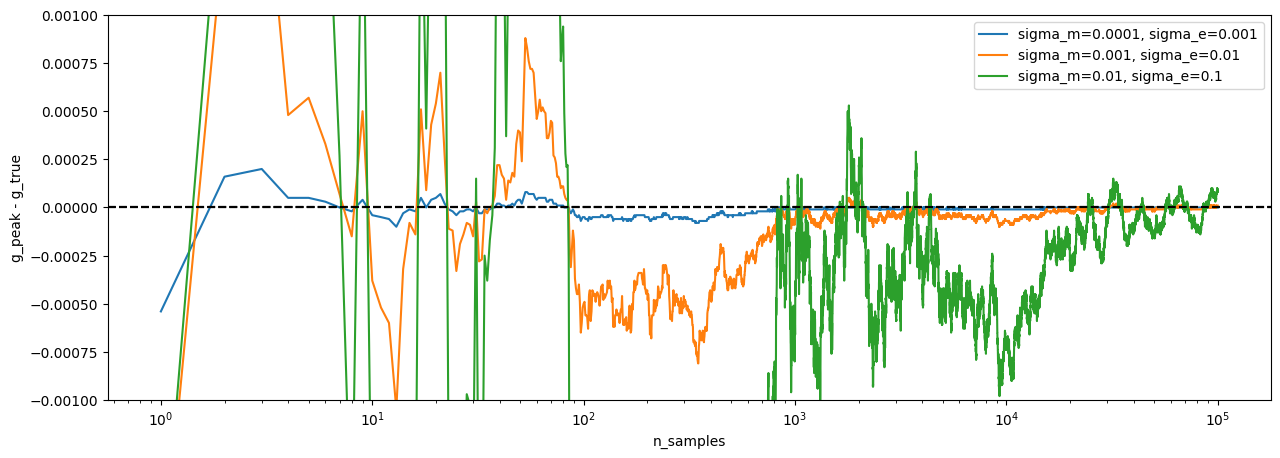

In [25]:
g1s = jnp.arange(0.018, 0.022, 0.00001)
plt.figure(figsize=(15, 5))

for sigma_m, sigma_e in tqdm(zip(sigma_ms, sigma_es)):
    
    e_obs, e_sheared, _ = sample_synthetic_sheared_ellips_unclipped(
    k1, g, n=n_gals, sigma_m=sigma_m, sigma_e=sigma_e
    )
    keys2 = random.split(k2, n_gals)
    _do_inference = partial(do_inference, sigma_e=sigma_e, sigma_m=sigma_m, m=50)
    e_post = jax.vmap(_do_inference, in_axes=(0, 0, 0))(keys2, e_sheared, e_obs)

    all_loglikes = get_all_loglikes(g1s, e_post, sigma_e=sigma_e)

    
    # plot
    ns = np.arange(1, n_gals+1, 1)
    _cumsum_like = jnp.cumsum(all_loglikes, axis=-1)
    g1_peaks = g1s[jnp.argmax(_cumsum_like, axis=0)]

    plt.plot(ns, g1_peaks - 0.02, label=f"sigma_m={sigma_m:.2g}, sigma_e={sigma_e:.2g}")
    # plt.xscale('log')
    plt.axhline(0.0, color='k', linestyle='--')

    plt.xlabel("n_samples")
    plt.ylabel("g_peak - g_true")


    # plt.axhline(0.02/1000)
    # plt.axhline(-0.02/1000)
plt.legend()
plt.xscale("log")
# plt.yscale("log")
plt.ylim(-0.001, 0.001)


0it [00:00, ?it/s]2024-09-23 14:31:02.116173: W external/xla/xla/service/hlo_rematerialization.cc:3005] Can't reduce memory use below 14.15GiB (15193090452 bytes) by rematerialization; only reduced to 14.36GiB (15424109168 bytes), down from 14.37GiB (15429009368 bytes) originally

1it [00:11, 11.11s/it]2024-09-23 14:31:14.759049: W external/xla/xla/service/hlo_rematerialization.cc:3005] Can't reduce memory use below 14.15GiB (15193090452 bytes) by rematerialization; only reduced to 14.36GiB (15424109168 bytes), down from 14.37GiB (15429009368 bytes) originally

2it [00:23, 12.04s/it]2024-09-23 14:31:25.873114: W external/xla/xla/service/hlo_rematerialization.cc:3005] Can't reduce memory use below 14.15GiB (15193090452 bytes) by rematerialization; only reduced to 14.36GiB (15424109168 bytes), down from 14.37GiB (15429009368 bytes) originally

3it [00:34, 11.63s/it]


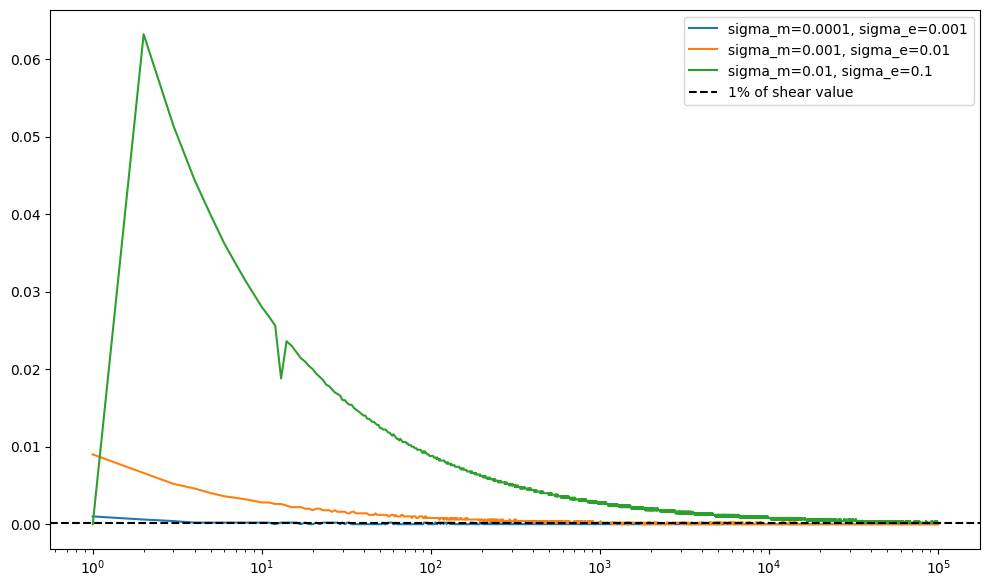

In [29]:
g1s = jnp.arange(0.00, 0.04, 0.0001)
plt.figure(figsize=(12, 7))

for sigma_m, sigma_e in tqdm(zip(sigma_ms, sigma_es)):
    
    e_obs, e_sheared, _ = sample_synthetic_sheared_ellips_unclipped(
    k1, g, n=n_gals, sigma_m=sigma_m, sigma_e=sigma_e
    )
    keys2 = random.split(k2, n_gals)
    _do_inference = partial(do_inference, sigma_e=sigma_e, sigma_m=sigma_m, m=50)
    e_post = jax.vmap(_do_inference, in_axes=(0, 0, 0))(keys2, e_sheared, e_obs)

    all_loglikes = get_all_loglikes(g1s, e_post, sigma_e=sigma_e)

    
    # plot
    ns = jnp.arange(1, n_gals+1, 1)
    _cumsum_loglike = jnp.cumsum(all_loglikes, axis=-1)
    _cumsum_like = _scale_likelihood(_cumsum_loglike, axis=0)

    _other_indx = jnp.argmax(_cumsum_like >= 0.9, axis=0) # first index that reaches 90%
    _peak_indx = jnp.argmax(_cumsum_like, axis=0)

    _width = (g1s[_peak_indx] - g1s[_other_indx]) * 2

    plt.plot(ns, _width, label=f"sigma_m={sigma_m:.2g}, sigma_e={sigma_e:.2g}")

plt.xscale('log')
# plt.yscale("log")
plt.axhline(0.02 / 100, color='k', linestyle='--', label="1% of shear value")
plt.legend()

# Shear posteriors unite!

## Get samples

In [50]:
key = jax.device_put(random.key(42), device=GPU)
k1, k2, k3 = random.split(key, 3)

g = 0.02, 0.
n_gals = int(1e5)

sigma_e = 1e-2
sigma_m = 1e-3

In [51]:
# get samples
e_obs, e_sheared, _ = sample_synthetic_sheared_ellips_unclipped(
k1, g, n=n_gals, sigma_m=sigma_m, sigma_e=sigma_e
)
e_obs.shape

(100000, 2)

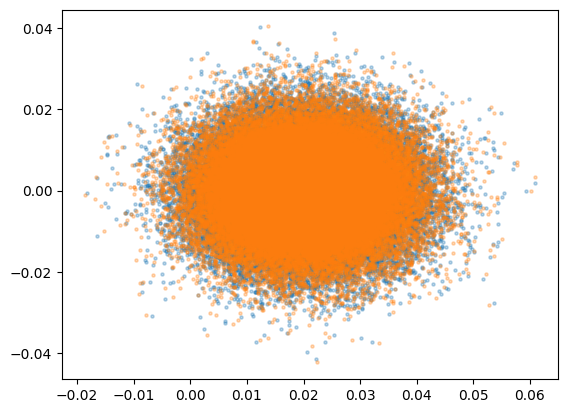

In [52]:
plt.scatter(e_obs[:, 0], e_obs[:, 1], s=5, alpha=0.3)
plt.scatter(e_sheared[:, 0], e_sheared[:, 1], s=5, alpha=0.3)

In [53]:
e_obs_gpu = jax.device_put(e_obs, device=GPU)
e_sheared_gpu = jax.device_put(e_sheared, device=GPU)
e_obs_gpu.devices()

{CudaDevice(id=0)}

In [54]:
keys2 = random.split(k2, n_gals)
_do_inference = jax.jit(partial(do_inference, sigma_e=sigma_e, sigma_m=sigma_m, m=50))
e_post = jax.vmap(_do_inference, in_axes=(0, 0, 0))(keys2, e_sheared_gpu, e_obs_gpu)
e_post_gpu = jax.device_put(e_post, device=GPU)
e_post_gpu.shape, e_post_gpu.devices()

((100000, 50, 2), {CudaDevice(id=0)})

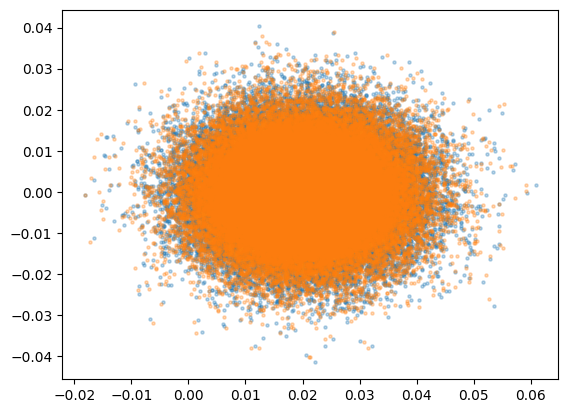

In [55]:
plt.scatter(e_obs[:, 0], e_obs[:, 1], s=5, alpha=0.3)
plt.scatter(e_post_gpu[:, 0, 0], e_post_gpu[:, 0, 1], s=5, alpha=0.3)

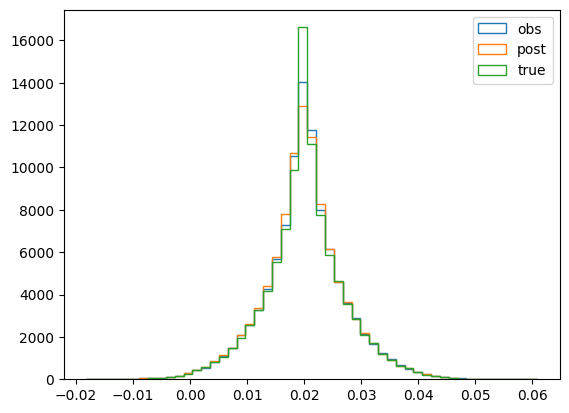

In [56]:
_, bins, _ = plt.hist(e_obs[:, 0], bins=51, histtype='step', label='obs')
plt.hist(e_post_gpu[:, 0, 0], bins=bins, histtype='step', label='post')
plt.hist(e_sheared[:, 0], bins=bins, histtype='step', label='true')
plt.legend()

## 1 chain over all galaxies

In [57]:
prior = partial(ellip_mag_prior, sigma=sigma_e)
interim_prior = partial(ellip_mag_prior, sigma=sigma_e * 2)
_loglikelihood_fnc = partial(shear_loglikelihood, prior=prior, interim_prior=interim_prior)

def logtarget_density2(g, e_post):
    loglike = _loglikelihood_fnc(g, e_post)
    logprior = stats.uniform.logpdf(g, -0.1, 0.2).sum()
    return logprior + loglike

def do_inference2(rng_key, init_g, logtarget, n_samples=1000):
    key1, key2 = random.split(rng_key)

    warmup = blackjax.window_adaptation(
        blackjax.nuts,
        logtarget,
        progress_bar=False,
        is_mass_matrix_diagonal=True,
        max_num_doublings=5,
        initial_step_size=0.01,
        target_acceptance_rate=0.80,
    )

    (init_states, tuned_params), _ = warmup.run(key1, init_g, 500)
    kernel = blackjax.nuts(logtarget, **tuned_params).step
    states, _ = inference_loop(key2, init_states, kernel=kernel, n_samples=n_samples)
    return states.position

In [58]:
_logtarget = partial(logtarget_density2, e_post=e_post_gpu)

In [70]:
init_g = jax.device_put(jnp.array([0.02, 0.0]), device=GPU)
g_samples = do_inference2(k3, init_g, _logtarget, n_samples=2000)
g_samples.shape

In [72]:
save_dataset_h5py({'g': g_samples}, "g_samples.hdf5")

In [74]:
g_samples2 = load_dataset_h5py('g_samples.hdf5')['g']
# jnp.allclose(g_samples_loaded['g'], g_samples)
g_samples2.shape

(2000, 2)

Parameter g1 in chain posterior is not constrained


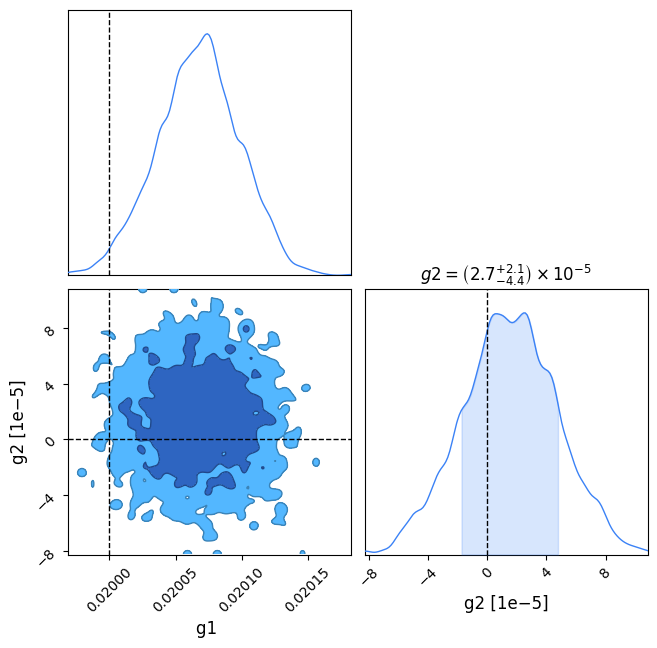

In [118]:
# contour plot
samples = {'g1': g_samples2[:, 0], 'g2': g_samples2[:, 1]}
truth = {'g1': 0.02, 'g2':0.00}
fig = get_contour_plot([samples], ['posterior'], truth, figsize=(7,7))

In [76]:
g_samples[:, 0].mean(), g_samples[:, 0].std()

(Array(0.02006723, dtype=float64), Array(3.11980428e-05, dtype=float64))

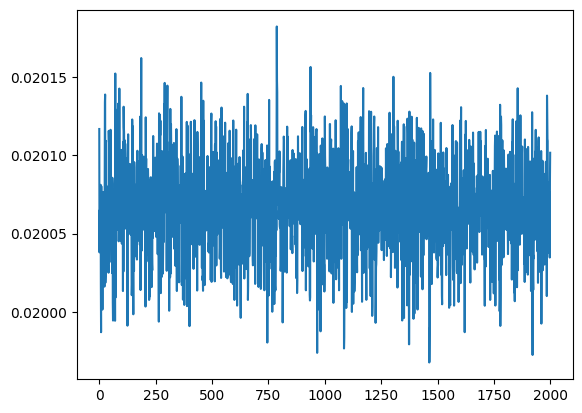

In [77]:
plt.plot(g_samples[:, 0])
# plt.plot(g_samples[:, 1])

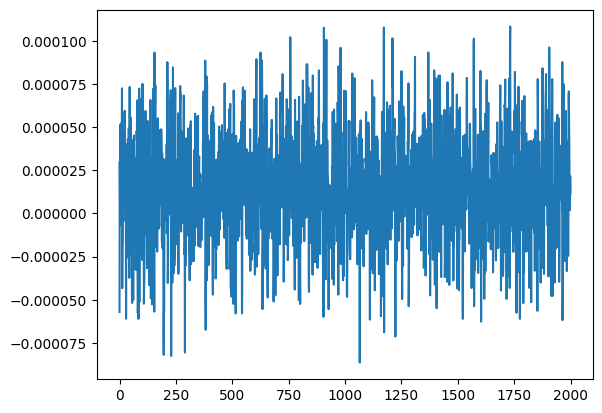

In [78]:
plt.plot(g_samples[:, 1])

## 1000 chains over 100 galaxies

In [84]:
def do_inference3(rng_key, init_g, e_post_gpu, n_warmups=1, n_samples=1000):
    _logtarget = partial(logtarget_density2, e_post=e_post_gpu)
    
    
    key1, key2 = random.split(rng_key)

    warmup = blackjax.window_adaptation(
        blackjax.nuts,
        _logtarget,
        progress_bar=False,
        is_mass_matrix_diagonal=True,
        max_num_doublings=5,
        initial_step_size=0.01,
        target_acceptance_rate=0.80,
    )

    (init_states, tuned_params), _ = warmup.run(key1, init_g, n_warmups)
    kernel = blackjax.nuts(_logtarget, **tuned_params).step
    states, _ = inference_loop(key2, init_states, kernel=kernel, n_samples=n_samples)
    return states.position

In [85]:
M=1000 #n_batches

In [86]:
# split data into batches
e_post_batches = e_post_gpu.reshape(M, 100, 50, 2)
e_post_batches.shape

(1000, 100, 50, 2)

In [87]:
init_gs = init_g.reshape(1, 2) * jnp.ones((M, 2))
init_gs.shape

(1000, 2)

In [88]:
keys3 = random.split(k3, M)

In [89]:
_do_inference3 = jax.vmap(partial(do_inference3, n_warmups=500, n_samples=100),in_axes=(0, 0, 0))

In [90]:
g_all_samples = _do_inference3(keys3, init_gs, e_post_batches)

In [91]:
g_all_samples.shape

(1000, 100, 2)

In [93]:
save_dataset_h5py({'g_batch_samples': g_all_samples}, 'g_batch_samples.hdf5')

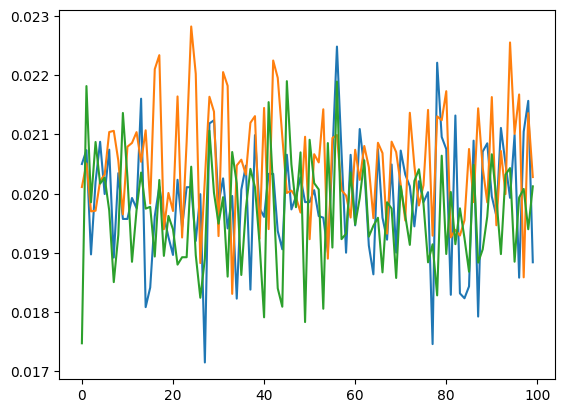

In [94]:
plt.plot(g_all_samples[0, :, 0])
plt.plot(g_all_samples[1, :, 0])
plt.plot(g_all_samples[-1, :, 0])

### Combine samples via gaussian posterior approximation

In [95]:
# combine samples via the procedure in https://arxiv.org/pdf/1311.4780
# assume that the p(g|D) is a Gaussian posterior
# need to make sure prior is p(g)^{1/M}
sample_mean = jnp.mean(g_all_samples, axis=1)
sample_covs = []
for ii in range(M):
    sample_covs.append(jnp.cov(g_all_samples[ii], rowvar=False))

sample_covs = jnp.array(sample_covs)

In [96]:
# get posterior sigma
sample_covs_inv = jnp.array([jnp.linalg.inv(sample_covs[ii]) for ii in range(M)])
sigma_tot = jnp.linalg.inv(jnp.sum(sample_covs_inv, axis=0))

In [97]:
# get posterior mean
els = []
for ii in range(M):
    els.append(sample_covs_inv[ii].dot(sample_mean[ii]))
els = jnp.array(els).sum(axis=0)

mean_tot = sigma_tot.dot(els)

In [98]:
mean_tot, jnp.sqrt(jnp.diag(sigma_tot))

(Array([2.00595460e-02, 1.45413414e-05], dtype=float64),
 Array([3.06906328e-05, 3.07164194e-05], dtype=float64))

In [99]:
(2.00595460e-02 - 0.02) / 0.02

0.00297730000000003

In [104]:
k = random.key(40)
g_final_samples = random.multivariate_normal(k, mean=mean_tot, cov=sigma_tot, shape=(2000,))

Parameter g1 in chain full is not constrained


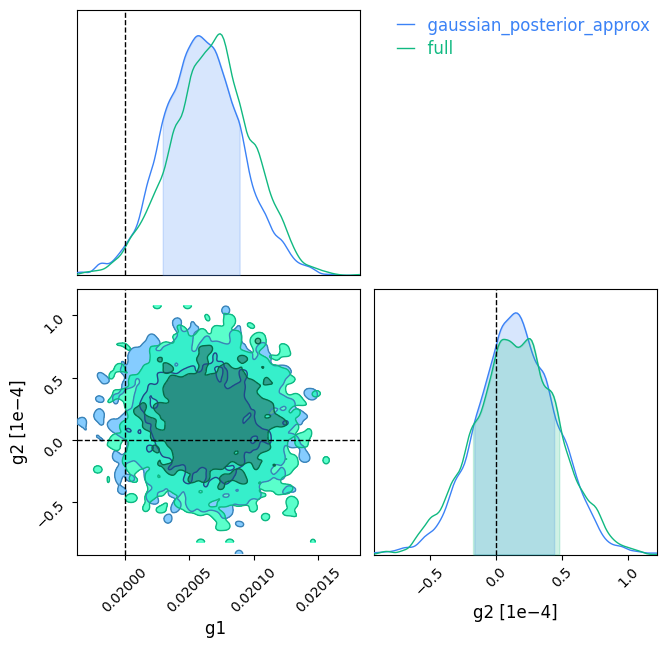

In [116]:
# contour plot
samples1 = {'g1': g_final_samples[:, 0], 'g2': g_final_samples[:, 1]}
samples2 = {'g1': g_samples2[:, 0], 'g2': g_samples2[:, 1]}
truth = {'g1': 0.02, 'g2':0.00}
fig = get_contour_plot( [samples1, samples2], ['gaussian_posterior_approx', 'full'], truth, figsize=(7,7))